# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev1 toc-item"><a href="#Load-Function" data-toc-modified-id="Load-Function-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Function</a></div><div class="lev2 toc-item"><a href="#Initialize-Vars" data-toc-modified-id="Initialize-Vars-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Initialize Vars</a></div>

# Import Libraries

In [4]:
"""
demo.py
Author: Gabriela Tavares, gtavares@caltech.edu

Demo of the attentional drift-diffusion model (aDDM), as described by Krajbich
set al. (2010).
"""

import argparse
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm

import sys
print(sys.version)

2.7.12 |Anaconda custom (x86_64)| (default, Jul  2 2016, 17:43:17) 
[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]


# Load Function

## Initialize Vars

In [30]:
class arguments:
    mean = 0.02
    sigma = 0.25
    barrier_size = 1
    barrier_decay = 0
    state_step = 0.1
    max_time = 200
    display_figures = True
    
args = arguments()

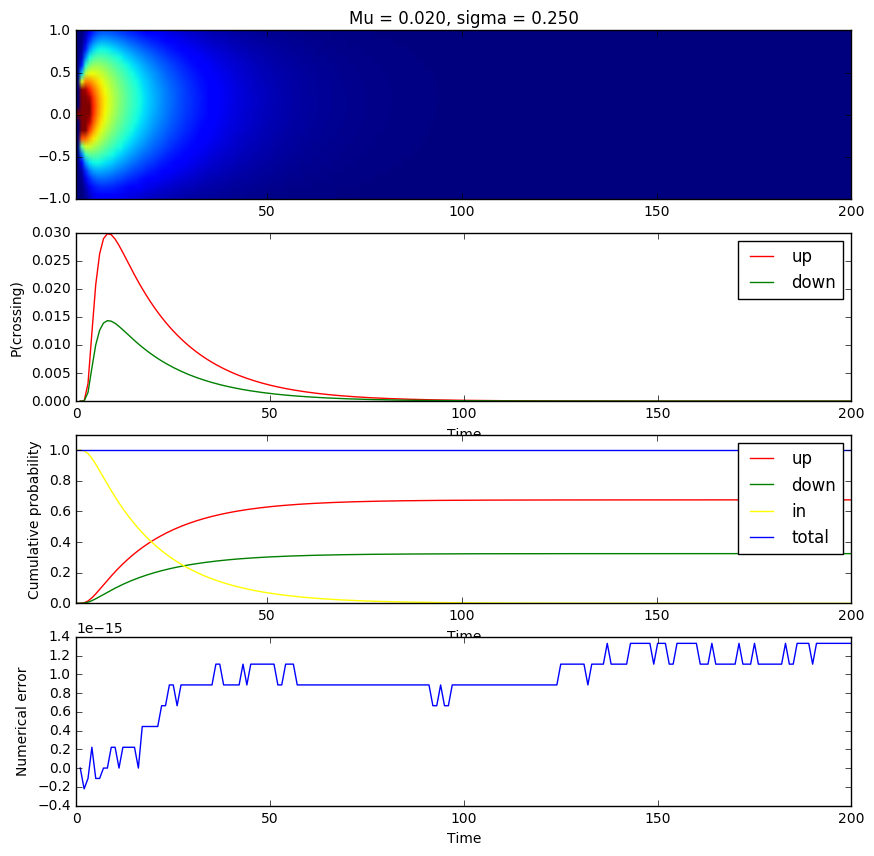

In [33]:
def main():

#     argparse is for command line implementation

#     parser = argparse.ArgumentParser()
#     parser.add_argument("--mean", type=float, default=0.05,
#                         help="Mean of the normal distribution.")
#     parser.add_argument("--sigma", type=float, default=0.25,
#                         help="Standard deviation of the normal distribution.")
#     parser.add_argument("--barrier-size", type=int, default=1,
#                         help="Initial size of the decision barriers.")
#     parser.add_argument("--barrier-decay", type=float, default=0,
#                         help="Parameter that controls the decay of the "
#                         "barriers over time. A decay of zero means the "
#                         "barriers are constant.")
#     parser.add_argument("--state-step", type=float, default=0.1,
#                         help="Step size for the RDV states.")
#     parser.add_argument("--max-time", type=int, default=200,
#                         help="Amount of time to run the algorithm, in "
#                         "miliseconds.")
#     parser.add_argument("--display-figures", default=False,
#                         action="store_true", help="Display plots showing the "
#                         "computation at the end of execution.")
#     args = parser.parse_args()

    initialBarrierUp = args.barrier_size
    initialBarrierDown = -args.barrier_size

    # The values of the barriers can change over time.
    barrierUp = initialBarrierUp * np.ones(args.max_time)
    barrierDown = initialBarrierDown * np.ones(args.max_time)
    for t in xrange(1, args.max_time):
        barrierUp[t] = initialBarrierUp / (1 + args.barrier_decay * (t + 1))
        barrierDown[t] = (initialBarrierDown /
                          (1 + args.barrier_decay * (t + 1)))

    # Obtain correct state step.
    approxStateStep = args.state_step
    halfNumStateBins = np.ceil(args.barrier_size / float(approxStateStep))
    stateStep = args.barrier_size / float(halfNumStateBins + 0.5)

    # The vertical axis is divided into states.
    states = np.arange(initialBarrierDown + (stateStep / 2.),
                       initialBarrierUp - (stateStep / 2.) + stateStep,
                       stateStep)

    # Initial probability for all states is zero, except the zero state, for
    # which the initial probability is one.
    prStates = np.zeros((states.size, args.max_time))
    prStates[np.where(states==0)[0], 0] = 1

    probUpCrossing = np.zeros(args.max_time)
    probDownCrossing = np.zeros(args.max_time)

    for t in xrange(1, args.max_time):
        prStatesNew = np.zeros(states.size)
        
        # Update the probability of the states that remain inside the barriers.
        for s in xrange(0,states.size):
            currState = states[s]
            if currState > barrierDown[t] and currState < barrierUp[t]:
                change = (currState * np.ones(states.size)) - states
                # The probability of being in state B is the sum, over all
                # states A, of the probability of being in A at the previous
                # time step times the probability of changing from A to B. We
                # multiply the probability by the state step to ensure that the
                # area under the curve for the probability distributions
                # probUpCrossing and probDownCrossing each add up to 1.
                prStatesNew[s] = (args.state_step * np.sum(
                    np.multiply(prStates[:,t-1],
                    norm.pdf(change, args.mean, args.sigma))))

        # Calculate the probabilities of crossing the up barrier and the down
        # barrier. This is given by the sum, over all states A, of the
        # probability of being in A at the previous timestep times the
        # probability of crossing the barrier if A is the previous state.
        changeUp = (barrierUp[t] * np.ones(states.size)) - states
        tempUpCross = np.sum(
            np.multiply(prStates[:,t-1],
            1 - norm.cdf(changeUp, args.mean, args.sigma)))
        changeDown = (barrierDown[t] * np.ones(states.size)) - states
        tempDownCross = np.sum(
            np.multiply(prStates[:,t-1],
                        norm.cdf(changeDown, args.mean, args.sigma)))

        # Renormalize to cope with numerical approximation.
        sumIn = np.sum(prStates[:,t-1])
        sumCurrent = np.sum(prStatesNew) + tempUpCross + tempDownCross
        prStatesNew = prStatesNew * sumIn / sumCurrent
        tempUpCross = tempUpCross * sumIn / sumCurrent
        tempDownCross = tempDownCross * sumIn / sumCurrent

        # Update the probabilities of each state and the probabilities of
        # crossing each barrier at this timestep. Note that the probabilities
        # at each time step DO NOT add up to 1. These probabilities account
        # only for the probability of the signal staying inside the barriers or
        # crossing a barrier at this time step, but not the probability of
        # already having crossed a barrier at an earlier time.
        prStates[:,t] = prStatesNew
        probUpCrossing[t] = tempUpCross
        probDownCrossing[t] = tempDownCross

    if args.display_figures:
        # Choose a suitable normalization constant.
        maxProb = max(prStates[:,3])
        
        # Size plots
        fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')

        plt.subplot(4, 1, 1)
        plt.imshow(prStates[::-1,:], extent=[1, args.max_time,
                                            -args.barrier_size,
                                             args.barrier_size],
                   aspect="auto", vmin=0, vmax=maxProb)
        plt.title("Mu = %.3f, sigma = %.3f" % (args.mean, args.sigma))

        plt.subplot(4, 1, 2)
        plt.plot(range(1, args.max_time + 1), probUpCrossing, label="up",
                 color="red")
        plt.plot(range(1, args.max_time + 1), probDownCrossing, label="down",
                 color="green")
        plt.xlabel("Time")
        plt.ylabel("P(crossing)")
        plt.legend()

        plt.subplot(4, 1, 3)
        probInner = np.sum(prStates, 0)
        probUp = np.cumsum(probUpCrossing)
        probDown = np.cumsum(probDownCrossing)
        probTotal = probInner + probUp + probDown
        plt.plot(range(1, args.max_time + 1), probUp, color="red",
                 label="up")
        plt.plot(range(1, args.max_time + 1), probDown, color="green",
                 label="down")
        plt.plot(range(1, args.max_time + 1), probInner, color="yellow",
                 label="in")
        plt.plot(range(1, args.max_time + 1), probTotal, color="blue",
                 label="total")
        plt.axis([1, args.max_time, 0, 1.1])
        plt.xlabel("Time")
        plt.ylabel("Cumulative probability")
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.plot(range(1, args.max_time + 1), probTotal - 1)
        plt.xlabel("Time")
        plt.ylabel("Numerical error")
        
        plt.show(block=True)


if __name__ == "__main__":
    main()

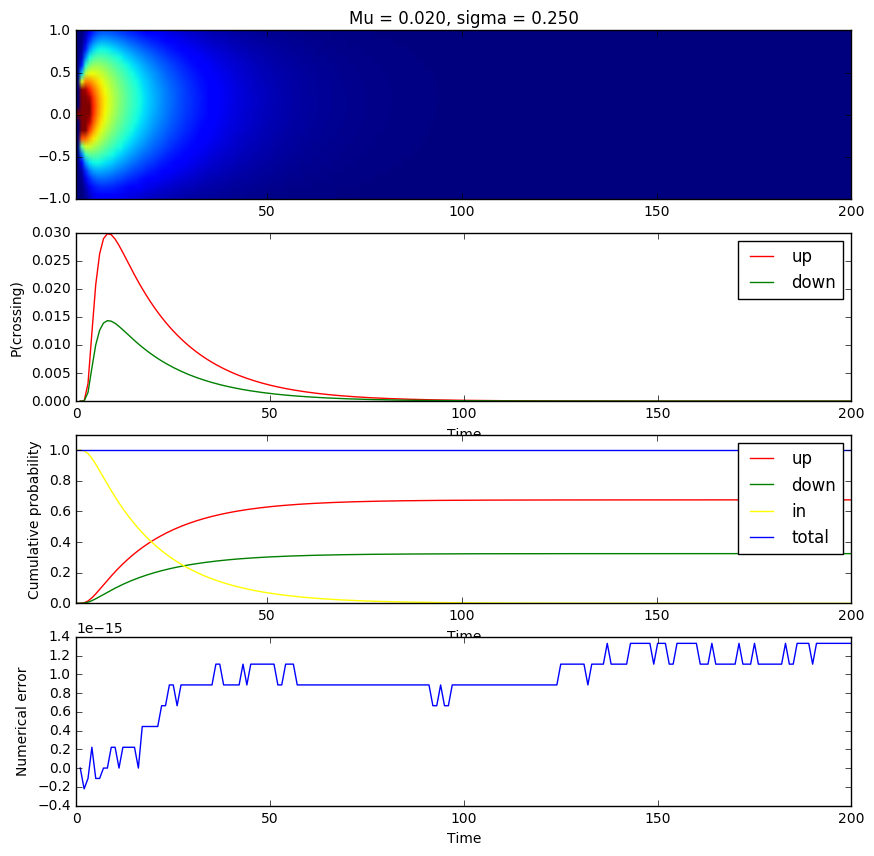

In [37]:
main()